In [4]:
#!/usr/bin/env python3
"""
Loading correlated noise example from ReadSpyn
"""

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from typing import Dict, List

# Import ReadSpyn components
import sys
import os
sys.path.append("../src/")

from readout_simulator.quantum_dot_system import QuantumDotSystem
from readout_simulator.sensor_backend import RLC_sensor
from readout_simulator.jax_simulator import JAXReadoutSimulator
from readout_simulator.noise_models import OU_noise, OverFNoise, CorrelatedNoise



In [134]:

# Set random seed for reproducibility
key = jr.PRNGKey(42)

# ------- QUANTUM DOT SYSTEM -------
Cdd = np.array([
    [1.0, 0.2, 0.1],  # Dot 1 self-capacitance and coupling to dot 2
    [0.2, 1.0, 0.1],   # Dot 2 self-capacitance and coupling to dot 1
    [0.1, 0.1, 1.0]   # Dot 3 self-capacitance and coupling to dot 1
])

# Dot-sensor capacitance matrix (2x2)
Cds = np.array([
    [0.5, 0.2, 0.1],  # Dot 1 coupling to sensors
    [0.2, 0.5, 0.3],
    [0.1, 0.3, 0.5]   # Dot 3 coupling to sensors
])

# Create quantum dot system
dot_system = QuantumDotSystem(Cdd, Cds)



# ------- SENSORS -------
params_resonator = {
        'Lc': 800e-9,           # Inductance (H)
        'Cp': 0.6e-12,          # Parasitic capacitance (F)
        'RL': 40,               # Load resistance (Ω)
        'Rc': 100e6,            # Coupling resistance (Ω)
        'Z0': 50.0,             # Characteristic impedance (Ω)
        'self_capacitance': 0   # Additional self-capacitance (F)
    }
    
# Coulomb peak parameters (identical for both sensors)
params_coulomb_peak = {
    'g0': 1/50,             # Maximum conductance (S)
    'eps0': 0.5,            # Operating point (relative to eps_width)
    'eps_width': 1.0        # Energy width (eV)
}

# Create two identical sensors
sensors = []
for i in range(3):
    sensor = RLC_sensor(params_resonator, params_coulomb_peak)
    sensors.append(sensor)
    print(f"Sensor {i+1} resonant frequency: {sensor.f0/1e9:.2f} GHz")


# ------- PHYSICAL NOISE -------
correlation_matrix = jnp.array([
        [1.0, 0.6, 0.6],
        [0.6, 1.0, 0.6],
        [0.6, 0.6, 1.0]
    ])

base_noise = OU_noise(sigma=1e0, gamma=1e4) 

correlated_noise = CorrelatedNoise(base_noise, correlation_matrix)
    
    # Create simulator
simulator = JAXReadoutSimulator(dot_system, sensors)
    
    # Define charge states to simulate
charge_states = jnp.array([
        [1, 0, 0],  # First dot occupied
        [0, 1, 0],  # Second dot occupied
        [0, 0, 1],  # Third dot occupied
    ])
    
    # Define simulation parameters
t_end = 1e-6  # 1 μs
dt = 0.5e-9   # 0.5 ns
times = jnp.arange(0, t_end, dt)
n_realizations = 1000
    
    
    # Precompute noise trajectories
simulator.precompute_noise(key, times, n_realizations, correlated_noise)
    
    # Run simulation
params = {'snr': 5.0, 't_end': t_end}
results = simulator.run_simulation(charge_states, times, params, key)
    


Dot-sensor coupling strength (Δε/ε_w): [[0.47563559 0.10063559 0.04237288]
 [0.08368644 0.45868644 0.24576271]
 [0.00211864 0.25211864 0.47457627]]
[RLC_sensor] Initialized with:
  Lc = 8.000e-07 H
  Cp = 6.000e-13 F
  Self-capacitance = 0.000e+00 F
  Total capacitance = 6.000e-13 F
  RL = 40 Ω
  Rc = 1.000e+08 Ω
  Z0 = 50.0 Ω
  R0 = 5.000e+01 Ω
  g0 = 2.000e-02 S
  eps_w = 1.000e+00 eV
  Resonant frequency = 2.297e+08 Hz
  Resonant period = 4.353e-09 s
  Capacitance noise model: None
  Energy noise model: None
Sensor 1 resonant frequency: 0.23 GHz
[RLC_sensor] Initialized with:
  Lc = 8.000e-07 H
  Cp = 6.000e-13 F
  Self-capacitance = 0.000e+00 F
  Total capacitance = 6.000e-13 F
  RL = 40 Ω
  Rc = 1.000e+08 Ω
  Z0 = 50.0 Ω
  R0 = 5.000e+01 Ω
  g0 = 2.000e-02 S
  eps_w = 1.000e+00 eV
  Resonant frequency = 2.297e+08 Hz
  Resonant period = 4.353e-09 s
  Capacitance noise model: None
  Energy noise model: None
Sensor 2 resonant frequency: 0.23 GHz
[RLC_sensor] Initialized with:
  Lc = 

In [135]:
correlated_noise

/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_19537/1198264487.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


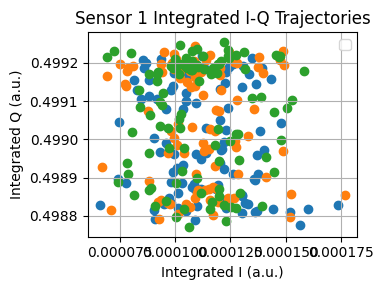

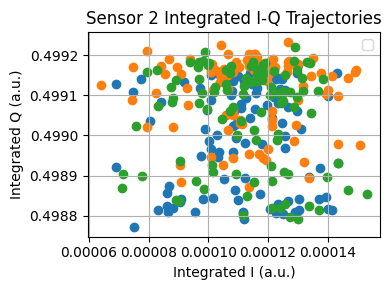

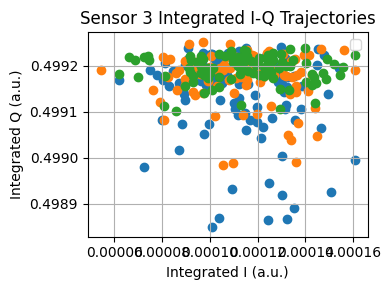

In [136]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare colors for each charge state
charge_state_labels = [
    "Dot 1 occupied",
    "Dot 2 occupied",
    "Dot 3 occupied"
]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Number of sensors and charge states
num_sensors = len(results['sensor_results'])
num_states = 3  # [1,0,0], [0,1,0], [0,0,1]
n_realizations = 100

# For each sensor, plot integrated I-Q for each charge state
for sensor_idx in range(num_sensors):
    plt.figure(figsize=(4, 3))
    for state_idx in range(num_states):
        # Get all realizations for this charge state
        I = results['sensor_results'][sensor_idx]['I'][state_idx, :]
        Q = results['sensor_results'][sensor_idx]['Q'][state_idx, :]
        # Integrate I and Q using cumulative sum along time axis
        I_int = np.cumsum(I, axis=1)/np.arange(1, I.shape[1]+1)
        Q_int = np.cumsum(Q, axis=1)/np.arange(1, Q.shape[1]+1)
        # Plot each realization as a faded line, then plot the mean
        for r in range(n_realizations):
            plt.scatter(I_int[r][-1], Q_int[r][-1], color=colors[state_idx], alpha=1)
        # Plot the mean integrated trajectory
        #plt.plot(I_int.mean(axis=0)[-1], Q_int.mean(axis=0)[-1], color=colors[state_idx], label=charge_state_labels[state_idx], linewidth=2)
    plt.xlabel("Integrated I (a.u.)")
    plt.ylabel("Integrated Q (a.u.)")
    plt.title(f"Sensor {sensor_idx+1} Integrated I-Q Trajectories")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()




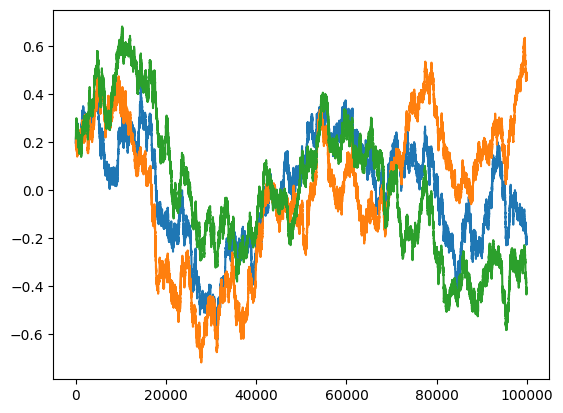

In [137]:
xi = [[],[],[]]
for i in range(50):
    for k in range(3):
        xi[k]+= list(np.array(results['sensor_results'][k]['noise_trajectory'][2][i].astype(float)))

for k in range(3):
    plt.plot(xi[k] - np.mean(xi[k]))
